In [16]:
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import callbacks
import datetime

import importlib


In [2]:
# project specific
from utils import data_handler
from utils.models import vae



In [3]:
%load_ext tensorboard
!rm -rf ../workfiles/logs/

### Generate dataset

In [22]:
importlib.reload(data_handler) # to allow modification of the script without restarting the whole session


<module 'utils.data_handler' from '/Users/aygalic/Library/CloudStorage/OneDrive-Personal/polimi/Thesis/genome_analysis_parkinson/src/utils/data_handler.py'>

In [23]:
#x_train, filenames = data_handler.generate_dataset(feature_selection_threshold = 5, retain_phases="2", return_filenames= True)
x_train, filenames = data_handler.generate_dataset(retain_phases="2", return_filenames= True)

retained phase 2
loading samples...
loaded 5740 samples
number of genes selected :  95309


### Generate model

In [24]:
importlib.reload(vae) # to allow modification of the script without restarting the whole session
#vae_model = vae.generate_model(shape = 6161)
vae_model = vae.generate_model(shape = 95309)



In [25]:
vae_model.compile(optimizer=keras.optimizers.Adam(), loss = keras.losses.mean_squared_error)

#### Train Model

In [26]:
checkpoint_filepath = '../workfiles/simple_autoencoer_model/checkpoint'
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True)


reduce_lr = callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5,
                              patience=15, min_lr=0.00001)

early_stopping_callback = callbacks.EarlyStopping(monitor='loss', patience=30)


log_dir = "../workfiles/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

cb = [model_checkpoint_callback, reduce_lr, early_stopping_callback, tensorboard_callback]

In [27]:
hist = vae_model.fit(x_train, epochs = 1000, callbacks = cb) 

Epoch 1/1000
45/45 [==============================] - 58s 1s/step - loss: 97815.4042 - reconstruction_loss: 90677.5000 - kl_loss: 121.0743 - lr: 0.0010
Epoch 2/1000
45/45 [==============================] - 61s 1s/step - loss: 72047.1705 - reconstruction_loss: 56115.6719 - kl_loss: 208.5036 - lr: 0.0010
Epoch 3/1000
45/45 [==============================] - 65s 1s/step - loss: 28555.8531 - reconstruction_loss: 25388.7832 - kl_loss: 190.9523 - lr: 0.0010
Epoch 4/1000
45/45 [==============================] - 61s 1s/step - loss: 20084.0429 - reconstruction_loss: 19999.1992 - kl_loss: 166.9674 - lr: 0.0010
Epoch 5/1000
45/45 [==============================] - 59s 1s/step - loss: 19395.5962 - reconstruction_loss: 19521.1035 - kl_loss: 157.9835 - lr: 0.0010
Epoch 6/1000
45/45 [==============================] - 53s 1s/step - loss: 19233.1099 - reconstruction_loss: 19390.3945 - kl_loss: 154.5212 - lr: 0.0010
Epoch 7/1000
45/45 [==============================] - 54s 1s/step - loss: 19173.7233 - r

KeyboardInterrupt: 

#### Monitoring training results

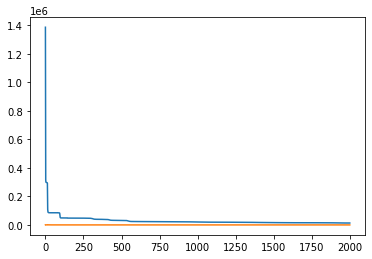

In [9]:
plt.plot(hist.history['reconstruction_loss'])
plt.plot(hist.history['kl_loss'])







In [10]:
e = iter(x_train).next()
_,__,z = vae_model.encoder(e)
print(z)
d = vae_model.decoder(z)
print(d)

tf.Tensor(
[[ 1.3942463   1.1073246  -0.249473   ...  1.748414    0.15733434
   0.60406435]
 [-0.5078156   0.9037626  -0.59862113 ... -1.1996845   1.2300029
  -0.2789621 ]
 [ 0.28314146 -0.02273649 -0.02136477 ...  0.2940514   0.5711944
  -0.976071  ]
 ...
 [ 1.0344222   1.0243697  -0.40951657 ... -0.04330308  0.24950421
  -0.7805939 ]
 [ 0.6370654   0.23689212 -0.6140728  ... -0.11022843  0.5270987
  -0.9653273 ]
 [ 0.47127447  0.6225651  -1.3892184  ... -1.4395599   0.79236335
  -0.6192606 ]], shape=(64, 64), dtype=float32)
tf.Tensor(
[[ 44.9941    43.11703   40.301586 ... 123.19259  140.64296  159.26526 ]
 [107.914665  55.244682  38.438107 ... 116.13901  169.28983  145.42177 ]
 [ 54.380016  53.34945   63.04656  ... 200.74075  200.06442  270.92914 ]
 ...
 [ 49.876236  51.23759   56.109165 ... 101.779366  60.312603 166.69931 ]
 [ 71.67892   57.613453  55.46396  ... 152.70917  157.26352  210.87466 ]
 [116.03614   63.59974   41.024914 ... 109.903885 173.00389  137.03603 ]], shape=(64, 6

In [11]:
#autoencoder.save('../workfiles/placeholder_model')
vae_model.encoder.save('../workfiles/vae_model_complex_phase_2')




INFO:tensorflow:Assets written to: ../workfiles/vae_model_complex_phase_2/assets


### encoding the whole dataset

In [12]:
_, __, compressed_dataframe = vae_model.encoder.predict(x_train)


45/45 [==============================] - 0s 4ms/step


In [13]:
df = pd.DataFrame(compressed_dataframe)
df["name"] = filenames

In [14]:
df.to_csv("../workfiles/compressed_data_vae_phase_2.csv")
